In [1]:
# %%capture
# %pip install -U transformers 
# %pip install -U datasets 
# %pip install -U accelerate 
# %pip install -U peft 
# %pip install -U trl 
# %pip install -U bitsandbytes 
# %pip install -U wandb
    
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import (
    LoraConfig,
    PeftModel,
    prepare_model_for_kbit_training,
    get_peft_model,
)
import os, torch, wandb
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig # Removed setup_chat_format as SFTTrainer handles it

from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

c:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'wandb'

In [ ]:
# --- Login ---
hf_token = user_secrets.get_secret("HUGGINGFACE_TOKEN")
login(token = hf_token)

wb_token = user_secrets.get_secret("WANDB_TOKEN")
wandb.login(key=wb_token)
run = wandb.init(
    project='Fine-tune Llama 3.1 8B on Text-to-SQL',
    job_type="training",
    anonymous="allow"
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: namasivaayaml (mepco-iot-7thsem) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# --- Configuration ---
base_model = "/kaggle/input/llama-3.1/transformers/8b-instruct/2"
new_model = "llama-3.1-8b-it-v2-fine-tuned-combined-complex-queries"
# Using a placeholder instruction - REPLACE with your actual instruction if it's static
# If it varies per example, you need a different formatting approach.
instruction = "Given the database schema and a question, generate the SQL query that answers the question."
dataset_name = "/kaggle/input/union-queries-v4-free-lance/training_data_v4.json"
MAX_SEQ_LENGTH = 2048 # IMPORTANT: Choose a reasonable max length

# --- Set torch dtype and attention implementation ---
if torch.cuda.get_device_capability()[0] >= 8:
    !pip install -qqq flash-attn # Already run in setup? Ensure it's installed
    print("Using Flash Attention 2 & BF16")
    torch_dtype = torch.bfloat16
    attn_implementation = "flash_attention_2"
    # Set TrainingArguments precision accordingly
    use_bf16 = True
    use_fp16 = False
else:
    print("Using Eager Attention & FP16")
    torch_dtype = torch.float16
    attn_implementation = "eager"
    # Set TrainingArguments precision accordingly
    use_bf16 = False
    use_fp16 = True

# --- QLoRA config ---
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch_dtype,
    bnb_4bit_use_double_quant=True,
)

Using Eager Attention & FP16


In [ ]:
# --- Load model ---
print("Loading model...")
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map="auto", # Let HF handle device placement
    attn_implementation=attn_implementation,
    torch_dtype=torch_dtype, # Set dtype during loading as well
)
print("Model loaded.")

# --- Load tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
# Set pad token if missing
if tokenizer.pad_token is None:
    print("Setting pad_token to eos_token")
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id # Ensure model config matches

# It's often better to prepare the model *before* adding LoRA adapters if using gradient checkpointing
model.gradient_checkpointing_enable() # Enable gradient checkpointing
model = prepare_model_for_kbit_training(model)

Loading model...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model loaded.
Setting pad_token to eos_token


In [ ]:
instruction = """
You are an expert Text-to-SQL converter specifically trained for the SALESIT database environment, likely using a Snowflake or PostgreSQL-like SQL dialect (supporting `||` concatenation and `lower()`). Your task is to translate the user's natural language question into a syntactically correct and executable SQL query based *only* on the provided database schema and adhering to specific standard structures and filtering logic.

**Core Task:** Generate a single, valid SQL query reflecting the user's request.

**Key Instructions & Standard Patterns:**

1.  **Schema Analysis:** Carefully examine the provided `CREATE TABLE` statements (or schema description) for table names (e.g., `ALL_OPPORTUNITY_VW`, `sfdc_rnwl_oppty_share_sales_level_vw`, `sfdc_rnwl_oppty_team_vw`), columns, types, and keys. Use exact, fully qualified names (e.g., `SALESIT_DB.SALESIT_SFDCANA_STG.ALL_OPPORTUNITY_VW`) and appropriate aliases (e.g., `opty`, `ssl`, `login_usr`, `otv`).
2.  **Standard Joins for Opportunities:** Queries involving "renewal opportunities" typically require joining `ALL_OPPORTUNITY_VW` (aliased as `opty`) with `sfdc_rnwl_oppty_share_sales_level_vw` (aliased as `ssl` for territory checks) and again with `sfdc_rnwl_oppty_share_sales_level_vw` (aliased as `login_usr` for user territory mapping). Often, a join to `sfdc_rnwl_oppty_team_vw` (aliased as `otv`) is also needed for comprehensive access checks.
    *   Territory Join: `opty.TERRITORY_ID = ssl.TERRITORYID`
    *   User Territory Join: `ssl.parent_territories LIKE '%' || login_usr.territory_name || '%'`
    *   Opportunity Team Join: `opty.opportunity_id = otv.opportunity_id`
3.  **Mandatory Filters:** Unless the user explicitly asks otherwise, *always* include these standard filters for opportunity queries:
    *   `opty.IS_CLOSED = FALSE`
    *   `opty.RECORD_TYPE_ID = '01234000000Boc4AAC'` (Renewal Opportunity Record Type)
    *   `WHERE 1 = 1` (Maintain this pattern if present in examples)
4.  **User Context Placeholders:**
    *   Recognize when the user's question implies context about the *requesting user* (e.g., "my opportunities", filtering implicit to the user).
    *   Use the placeholders `{{logged_user}}` (representing the logged-in user's alias/ID) and `{{req_user}}` (representing the user making the request, potentially for wider access checks) in the `WHERE` clauses to filter data based on user permissions, ownership, territory, and opportunity team access.
    *   Apply standard user filtering logic, often involving `lower()` for case-insensitive matching against fields like `OPPORTUNITY_OWNER_FULLNAME`, `opportunity_owner_userid`, `opty_access_users_list`, `ssl.alias`, `ssl.user_full_name`. Examples:
        *   `login_usr.alias = '{{logged_user}}'`
        *   Complex `OR` conditions checking ownership/access lists against `{{req_user}}` (e.g., `(lower(OPPORTUNITY_OWNER_FULLNAME) LIKE lower('%{{req_user}}%') OR opportunity_owner_userid = '{{req_user}}' OR lower(opty_access_users_list) LIKE lower('%{{req_user}}%'))` )
5.  **Standard UNION Structure:** Many queries require a `UNION` of two similar `SELECT DISTINCT` statements. This often accounts for different permission paths (e.g., direct access/team membership vs. territory hierarchy). The second part of the `UNION` might have slightly simpler permission checks (e.g., omitting the `otv` join and related checks). Apply this `UNION` structure consistently for standard opportunity requests.
6.  **Standard Output Columns:** For opportunity queries, typically select the following columns unless specified otherwise: `opty.opportunity_id`, `OPPORTUNITY_OWNER_FULLNAME`, `opportunity_name`, `deal_id`, `stage_name`, `close_date`, `prior_contract_expiration_date`, `account_name`, `prior_contract_notes`, `prior_sales_order_number_s`, `expected_product_amt`, `expected_service_amt`, `expected_total_atr_000s`. Use `DISTINCT`.
7.  **Standard Ordering & Limit:** Unless the user specifies otherwise, end the query with `ORDER BY EXPECTED_TOTAL_ATR_000S desc LIMIT 1000`.
8.  **Interpret User Criteria:** Map the specific criteria from the user's question (e.g., `stage_name = '3 - Proposal'`, `TOTAL_PRIOR_ATR_000S > 25.0`, `ACCOUNT_COUNTRY = UPPER('PANAMA')`) into the appropriate `WHERE` clause conditions within *both* parts of the `UNION` structure. Handle case sensitivity appropriately (e.g., using `lower()` or `UPPER()`).
9.  **Schema Adherence:** Only use tables and columns explicitly mentioned in the provided schema. Do not invent tables, columns, or relationships.
10. **Output Format:** Respond *only* with the generated SQL query. Do not include any explanations, comments, markdown formatting (like ```sql ... ```), or introductory text.

**Example Interaction Flow:**

1.  System receives Schema + User Question + User Context (`logged_user`, `req_user`).
2.  System applies instructions above, constructing the complex SQL with standard joins, filters, UNION, user context placeholders, specific user criteria, ordering, and limit.
3.  System outputs *only* the final SQL query.
    """

In [ ]:
# --- Load and prepare dataset ---
print("Loading dataset...")
data_files = {"train": dataset_name}
dataset = load_dataset("json", data_files=data_files)["train"]
dataset = dataset.train_test_split(test_size=0.1, seed=42)
print("Dataset loaded and split.")

# --- Formatting function ---
# Ensure you have the 'instruction' defined globally or passed correctly
def formatting_prompts_func(examples):
    output_texts = []
    for i in range(len(examples["question"])):
        # Assumes a fixed 'instruction' defined globally
        # If instruction is part of your JSON per row, use examples["instruction"][i]
        messages = [
            {"role": "system", "content": instruction},
            {"role": "user", "content": examples["question"][i]},
            {"role": "assistant", "content": examples["query"][i]}
        ]
        # Apply template, DON'T tokenize here, SFTTrainer handles it
        chat_string = tokenizer.apply_chat_template(messages, tokenize=False)
        output_texts.append(chat_string)
        
    return {"text": output_texts } # Create the 'text' column SFTTrainer expects by default

print("Mapping formatting function...")
# Important: Use remove_columns to avoid carrying unused data into the trainer
columns_to_remove = list(dataset['train'].features)
if "text" in columns_to_remove: # Don't remove the column we just created
     columns_to_remove.remove("text")
     
train_dataset = dataset['train'].map(
    formatting_prompts_func,
    batched=True,
    remove_columns=columns_to_remove # Remove original columns
)
eval_dataset = dataset['test'].map(
    formatting_prompts_func,
    batched=True,
    remove_columns=columns_to_remove # Remove original columns
)
print("Dataset formatting complete.")
print("Sample formatted text:", train_dataset[1]['text']) # Verify format

Loading dataset...
Dataset loaded and split.
Mapping formatting function...
Dataset formatting complete.
Sample formatted text: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an expert Text-to-SQL converter specifically trained for the SALESIT database environment, likely using a Snowflake or PostgreSQL-like SQL dialect (supporting `||` concatenation and `lower()`). Your task is to translate the user's natural language question into a syntactically correct and executable SQL query based *only* on the provided database schema and adhering to specific standard structures and filtering logic.

**Core Task:** Generate a single, valid SQL query reflecting the user's request.

**Key Instructions & Standard Patterns:**

1.  **Schema Analysis:** Carefully examine the provided `CREATE TABLE` statements (or schema description) for table names (e.g., `ALL_OPPORTUNITY_VW`, `sfdc_rnwl_oppty_share_sales_level_vw`, `

In [ ]:
# --- LoRA Config ---
# Define the target modules for Llama 3 (check model card or experiment)
# Common targets for Llama-like models:
target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']

peft_config = LoraConfig(
    r=16, # You can try reducing this to 8 if memory is still tight
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=target_modules # Use the defined list
)

# Apply PEFT model AFTER preparing for kbit training
model = get_peft_model(model, peft_config)
model.print_trainable_parameters() # Good practice to check

# --- Training Arguments ---
training_arguments = SFTConfig(
    output_dir=new_model,
    per_device_train_batch_size=1,  # REDUCED batch size
    per_device_eval_batch_size=1,   # Keep eval batch size low
    gradient_accumulation_steps=8, # INCREASED accumulation to compensate (effective batch size 1*8=8)
    optim="paged_adamw_32bit",
    num_train_epochs=1,
    eval_strategy="steps",    # Changed from 'eval_strategy'
    eval_steps=0.2,                 # Evaluate every 20% of steps
    logging_steps=10,               # Log less frequently to reduce noise
    warmup_steps=10,
    logging_strategy="steps",
    learning_rate=2e-4,
    fp16=use_fp16,                  # ENABLED mixed precision
    bf16=use_bf16,                  # ENABLED mixed precision
    # gradient_checkpointing=True,  # MOVED enabling this earlier for kbit compatibility
    group_by_length=True,           # Helps pack batches efficiently
    lr_scheduler_type="cosine",     # A common scheduler
    report_to="wandb",
    
    # Important for gradient checkpointing compatibility
    # ddp_find_unused_parameters=False, # Only needed for DDP, not single GPU
    
    # tokenizer=tokenizer,            # PASS the tokenizer
    dataset_text_field="text",      # EXPLICITLY specify the text field
    max_seq_length=MAX_SEQ_LENGTH,  # EXPLICITLY set max sequence length
    packing=False,                  # Set packing to False, as we pre-formatted
)

# --- SFT Trainer ---
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=peft_config,
    args=training_arguments,
)

# --- Train ---
print("Starting training...")
# Optional: Clear cache just before training (might help slightly with fragmentation)
# torch.cuda.empty_cache()
trainer.train()
print("Training finished.")

# --- Finish W&B Run ---
wandb.finish()

trainable params: 41,943,040 || all params: 8,072,204,288 || trainable%: 0.5196


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting training...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


KeyboardInterrupt: 

In [ ]:
# --- Inference Example ---
print("\n--- Running Inference Example ---")
# Ensure model is on GPU for inference if device_map put parts elsewhere
# model.to("cuda") # Usually device_map='auto' handles this, but double-check if needed

messages = [{"role": "system", "content": instruction},
    {"role": "user", "content": "Can you provide me with renewal opportunities where the stage is '3 - Proposal'?"}]

prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

inputs = tokenizer(prompt, return_tensors='pt', padding=False, truncation=True).to(model.device) # Use model.device

# Generate text
# Use torch.no_grad() for inference to save memory
with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=512, num_return_sequences=1, # Reduced max_new_tokens a bit
                             do_sample=True, # Add sampling for potentially better results
                             temperature=0.6,
                             top_p=0.9,
                             pad_token_id=tokenizer.eos_token_id) # Ensure pad token is EOS

text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Try to robustly extract the assistant's response
assistant_response = text.split("<|start_header_id|>assistant<|end_header_id|>")[-1].strip()
# Or if using older templates maybe: text.split("assistant")[-1].strip()

print("\nGenerated Query:")
print(assistant_response) # Print only the assistant part

In [ ]:
# --- Save Model ---
print("\n--- Saving Model ---")
trainer.model.save_pretrained(new_model) # Saves only the adapters
# For merging later (requires more memory/CPU):
# del model # Free VRAM
# torch.cuda.empty_cache()
# base_model_reload = AutoModelForCausalLM.from_pretrained(base_model, torch_dtype=torch_dtype, device_map='cpu') # Load on CPU
# model = PeftModel.from_pretrained(base_model_reload, new_model)
# model = model.merge_and_unload()
# model.save_pretrained(f"{new_model}-merged")
# tokenizer.save_pretrained(f"{new_model}-merged")

# Push adapters to hub
try:
    trainer.model.push_to_hub(new_model, use_temp_dir=False)
    tokenizer.push_to_hub(new_model, use_temp_dir=False) # Push tokenizer too
    print("Model and tokenizer pushed to hub.")
except Exception as e:
    print(f"Error pushing to hub: {e}")

In [ ]:
# # --- Evaluation Script (Run Separately or After Freeing Memory) ---
# # It's safer to run evaluation in a separate step/script if memory is tight
# # If you run it here, ensure you have enough VRAM *after* training.

# print("\n--- Running Evaluation Script ---")
# from torch.utils.data import DataLoader
# import json
# from tqdm import tqdm

# # Reload the dataset if necessary (might have been modified by trainer)
# dataset = load_dataset("json", data_files=data_files)["train"]

# # Ensure tokenizer has pad token for batching
# if tokenizer.pad_token is None:
#     tokenizer.pad_token = tokenizer.eos_token

# def collate_fn_eval(batch):
#     prompts = []
#     for example in batch:
#         messages = [{"role": "system", "content": instruction},
#                     {"role": "user", "content": example["question"]}]
#         prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
#         prompts.append(prompt)

#     # Tokenize the batch of prompts
#     tokenized = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_SEQ_LENGTH).to(model.device) # Use model.device

#     questions = [example["question"] for example in batch]
#     queries = [example["query"] for example in batch]
#     return tokenized, questions, queries

# # Use a smaller batch size for evaluation if necessary
# eval_batch_size = 2 # ADJUST AS NEEDED
# dataloader = DataLoader(dataset, batch_size=eval_batch_size, collate_fn=collate_fn_eval)

# results = []
# model.eval() # Set model to evaluation mode

# print("Generating predictions for evaluation...")
# for inputs, questions, queries in tqdm(dataloader):
#     with torch.no_grad(): # Ensure no gradients are computed
#         # Generate predictions
#         outputs = model.generate(
#             **inputs,
#             max_new_tokens=512, # Max length for the generated SQL
#             num_return_sequences=1,
#             pad_token_id=tokenizer.eos_token_id
#             )

#     # Decode outputs - skip special tokens AND the prompt part
#     # We need to decode individually and remove the prompt contamination
#     decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)

#     # Extract only the generated part after the prompt
#     model_queries = []
#     input_lengths = inputs['input_ids'].shape[1] # Length of the tokenized prompt
#     for i in range(len(decoded_outputs)):
#          # Decode only the generated tokens
#          generated_tokens = outputs[i][input_lengths:]
#          mq = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
#          # Alternative (less reliable) split method:
#          # mq = decoded_outputs[i].split("<|start_header_id|>assistant<|end_header_id|>")[-1].strip()
#          model_queries.append(mq)


#     for q, gt, mq in zip(questions, queries, model_queries):
#         results.append({
#             "question": q,
#             "query": gt,
#             "model_query": mq
#         })

# print(f"Generated {len(results)} predictions.")
# # Save results to a file
# output_filename = "complex_queries_train_model_predictions.json"
# print(f"Saving predictions to {output_filename}...")
# with open(output_filename, "w") as f:
#     json.dump(results, f, indent=4)
# print("Predictions saved.")

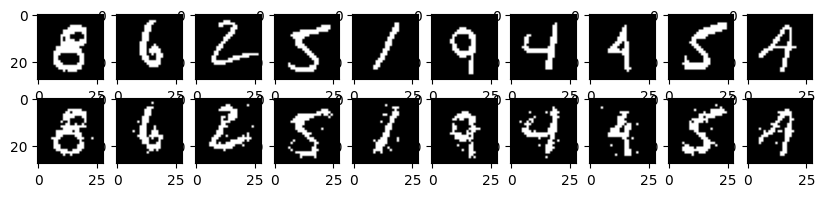

In [30]:
test_batch, _ = next(iter(train_dataset))
test_batch = test_batch.view(-1, 784)
test_batch = (test_batch > 0.5).float()
image_gen = obj(test_batch)
image_gen = image_gen.view(-1, 28, 28)
fig, ax = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    ax[0, i].imshow(test_batch[i].view(28, 28).detach().numpy(), cmap = "gray")
    ax[1, i].imshow(image_gen[i].detach().numpy(), cmap = "gray")
plt.show()

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. Load MNIST data
transform = transforms.Compose([transforms.ToTensor()])
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True
)

# 2. Define RBM class
class RBM(nn.Module):
    def __init__(self, visible_units=784, hidden_units=256):
        super(RBM, self).__init__()
        
        # Weight matrix of size (hidden_units x visible_units)
        # Each weight connects a visible unit to a hidden unit
        self.W = nn.Parameter(torch.randn(hidden_units, visible_units) * 0.01)
        
        # Hidden bias: one bias for each hidden unit
        self.h_bias = nn.Parameter(torch.zeros(hidden_units))
        
        # Visible bias: one bias for each visible unit
        self.v_bias = nn.Parameter(torch.zeros(visible_units))

    # Sample hidden units given visible units
    def sample_h(self, v):
        h_prob = torch.sigmoid(F.linear(v, self.W, self.h_bias))  # P(h=1|v)
        h_sample = torch.bernoulli(h_prob)  # Sample binary states
        return h_prob, h_sample

    # Sample visible units given hidden units
    def sample_v(self, h):
        v_prob = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))  # P(v=1|h)
        v_sample = torch.bernoulli(v_prob)
        return v_prob, v_sample

    # One forward step: visible → hidden → visible
    def forward(self, v):
        h_prob, h_sample = self.sample_h(v)
        v_prob, v_sample = self.sample_v(h_sample)
        return v_prob, v_sample

    # Contrastive Divergence: one-step CD to update weights
    def contrastive_divergence(self, v, lr=0.1):
        h_prob0, h_sample0 = self.sample_h(v)              # Positive phase
        v_prob, v_sample = self.sample_v(h_sample0)        # Reconstruct v
        h_prob1, _ = self.sample_h(v_prob)                 # Negative phase

        # Update weights    
        self.W.data += lr * (torch.matmul(h_prob0.t(), v) - torch.matmul(h_prob1.t(), v_prob)) / v.size(0)
        self.v_bias.data += lr * torch.mean(v - v_prob, dim=0)
        self.h_bias.data += lr * torch.mean(h_prob0 - h_prob1, dim=0)

# 3. Initialize and train RBM
rbm = RBM()
epochs = 5

for epoch in range(epochs):
    total_loss = 0
    for batch, _ in train_loader:
        batch = batch.view(-1, 784)          # Flatten 28x28 images to 784
        batch = (batch > 0.5).float()        # Binarize input

        # v_prob, v_sample = rbm.forward(batch)  # Reconstruct
        # loss = torch.mean((batch - v_prob)**2) # Reconstruction loss
        # total_loss += loss.item()

        rbm.contrastive_divergence(batch)     # Update weights

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1, Loss: 0.0000
Epoch 2, Loss: 0.0000
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000


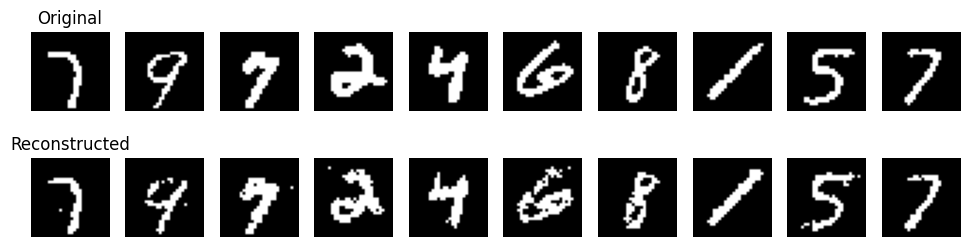

In [3]:
# Take a test batch from training set
test_batch, _ = next(iter(train_loader))
test_batch = test_batch.view(-1, 784)
test_batch = (test_batch > 0.5).float()

# Reconstruct
with torch.no_grad():
    _, reconstructed = rbm.forward(test_batch)

# Plot original and reconstructed digits
fig, axs = plt.subplots(2, 10, figsize=(12, 3))
for i in range(10):
    axs[0, i].imshow(test_batch[i].view(28, 28), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(reconstructed[i].view(28, 28), cmap='gray')
    axs[1, i].axis('off')
axs[0, 0].set_title("Original")
axs[1, 0].set_title("Reconstructed")
plt.show()
